Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Best Parameters: {'C': 10, 'max_iter': 1000, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.6031

Classification Report:
               precision    recall  f1-score   support

           5       0.70      0.74      0.72       149
           6       0.54      0.38      0.45       128
           7       0.46      0.77      0.57        43

    accuracy                           0.60       320
   macro avg       0.57      0.63      0.58       320
weighted avg       0.61      0.60      0.59       320



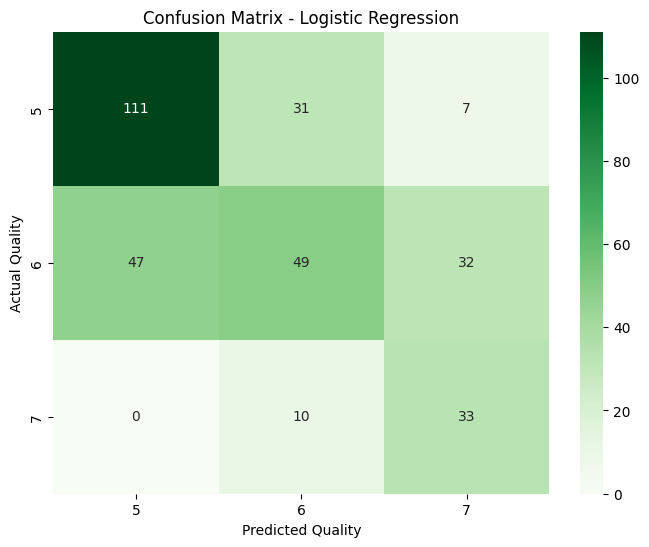

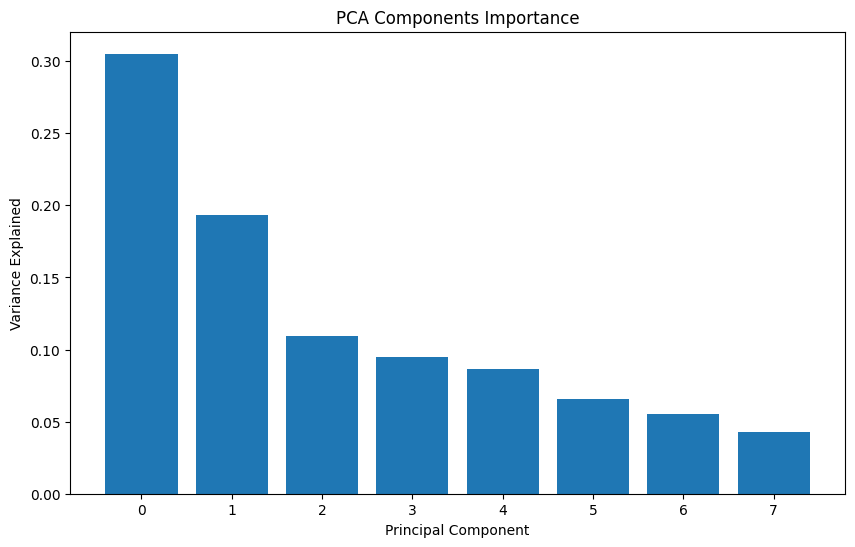

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Load and clean data
data = pd.read_csv("/content/drive/MyDrive/wineQualityReds.csv")
data = data.iloc[:, 1:]  # Remove index column

# Simplify target classes (merge low and high ratings)
def simplify_labels(y):
    y = np.where(y <= 5, 5, y)
    y = np.where(y == 6, 6, y)
    y = np.where(y >= 7, 7, y)
    return y

# Feature engineering
data['total_acidity'] = data['fixed.acidity'] + data['volatile.acidity']
data['sulfur_ratio'] = data['free.sulfur.dioxide'] / (data['total.sulfur.dioxide'] + 1e-6)
data['alcohol_acidity_ratio'] = data['alcohol'] / (data['volatile.acidity'] + 0.1)

X = data.drop('quality', axis=1).values
Y = simplify_labels(data['quality'].values)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# Preprocessing: power transform + robust scaling
preprocessor = PowerTransformer(method='yeo-johnson')
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# PCA for dimensionality reduction
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# SMOTE for balancing classes
smote = SMOTE(random_state=42)
X_train, Y_train = smote.fit_resample(X_train, Y_train)

# Logistic Regression + Grid Search
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'penalty': ['l2'],
    'multi_class': ['multinomial'],
    'max_iter': [1000]
}

grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, Y_train)
best_logreg = grid_search.best_estimator_

# Evaluation
Y_pred = best_logreg.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['5', '6', '7'],
            yticklabels=['5', '6', '7'])
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# PCA Component Plot
plt.figure(figsize=(10,6))
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('PCA Components Importance')
plt.show()
